## Network Dispersion on vertex level

* 1D for grad 1 or 2
    * within (TTest over networks)
    * between (TTest over network-dyads)
* (2D now in networkDispersion_03 ! )
* plot dispersion (average per group)
* correlate (within network dispersion) with behavioral measures


### Info:
* Plot group average networks to vis. between network dispersion in `groupComparisons_02`
* whole brain TTest between grad loadings also in `groupComparisons_02`

In [1]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import nibabel as nib
import matplotlib.pyplot as plt
import pingouin

bids_folder = '/mnt_03/ds-dnumrisk' 
phenotype_folder = op.join(bids_folder, 'derivatives/phenotype')

subList = [f[4:6] for f in os.listdir(bids_folder) if f[0:4] == 'sub-' and len(f) == 6]

# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group','age']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()

# plotting
fsaverage = fetch_surf_fsaverage() # default 5


In [2]:
from utils import get_glasser_parcels, get_glasser_CAatlas_mapping
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()

from brainspace.utils.parcellation import map_to_labels
caNets_fsav5_mapping = map_to_labels(glasser_CAatlas_mapping['ca_network'].values , labeling_glasser, mask=mask_glasser) #, fill=np.nan) #grad_sub[n_grad-1]


In [3]:
from utils_02 import get_all_behavior

df_behav = get_all_behavior(bids_folder)

In [22]:
# gradient values, vertex x subject
n_grad = 2

gms_aligned = [None] * len(subList)
for i, sub in enumerate(subList):
    source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
    gm_aligned = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_space-fsaverag5_n10.npy')) # sub-01_g-aligned_space-fsaverag5_n10.npy
    gms_aligned[i] = gm_aligned[n_grad-1,:] # only one grad to start with

# to create multidimensional array with all subs, grads & parcels, look at asym_grad....
sub_array= np.array([int(i) for i in subList]) 
n_vertices = np.shape(gms_aligned)[1] # 180

In [23]:
g1 = np.array(gms_aligned).T # n_vertices x n_subjects
N_nets = len(np.unique(caNets_fsav5_mapping)[1:]) # remove network-label=0

# compute for each subject and for each yeo network a) network centroid position; b) within network dispersion metric (higher value = wider distribution = more dispersion)
centroids_net = []  # center of gravity (median) for given network (i.e., network centroid position) (7 x 1000)
WN_dispersion = []  # Within network dispersion: sum squared Euclidean distance of network nodes to the network centroid at individual level (7 x 1000)


for n_network in np.unique(caNets_fsav5_mapping)[1:]:
    
    # identify the nodes of given Yeo network
    netNodes = np.where(caNets_fsav5_mapping == (n_network))[0] # get (glasser space) indices
    netNodes = np.squeeze(netNodes)
    
    # get the gradient loadings of the nodes of the given Yeo network, for each subject (shape: number of nodes in network x N)
    G1_net = g1[netNodes]
    
    ### identify the centroid / center of gravity (= median) of the given Yeo network for each subject (shape: N)
    centroid_cog_net = np.nanmedian(G1_net, axis=0)  #np.median(G1_net, axis=0)  
    centroids_net.append(centroid_cog_net)
    
    ### within network dispersion: 1 within network dispersion value per subject (per network)
    
    # compute (per subject) the Eucledian distance between each gradient loading (in Yeo network) and that network's centroid
    dist_nodes_to_centroid = G1_net - centroid_cog_net  # shape: number of nodes in network x N
    
    # take the sum of squares of this Eucledian distance 
    sum_of_squares = np.nanmean((dist_nodes_to_centroid**2), axis = 0)  # shape: N # sum originally!!
    
    # append to list
    WN_dispersion.append(sum_of_squares)
    
centroids_net = np.array(centroids_net)
WN_dispersion = np.array(WN_dispersion)

In [24]:
measure_of_interest =   'Within network dispersion' #  'Network midpoint (centroid)' #

if measure_of_interest == 'Within network dispersion':
    data = WN_dispersion 
elif measure_of_interest == 'Network midpoint (centroid)':
    data = centroids_net
    
df = pd.DataFrame(np.array(data.T), index=sub_array, columns = [f"net_{i+1}" for i in range(N_nets)])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)

/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


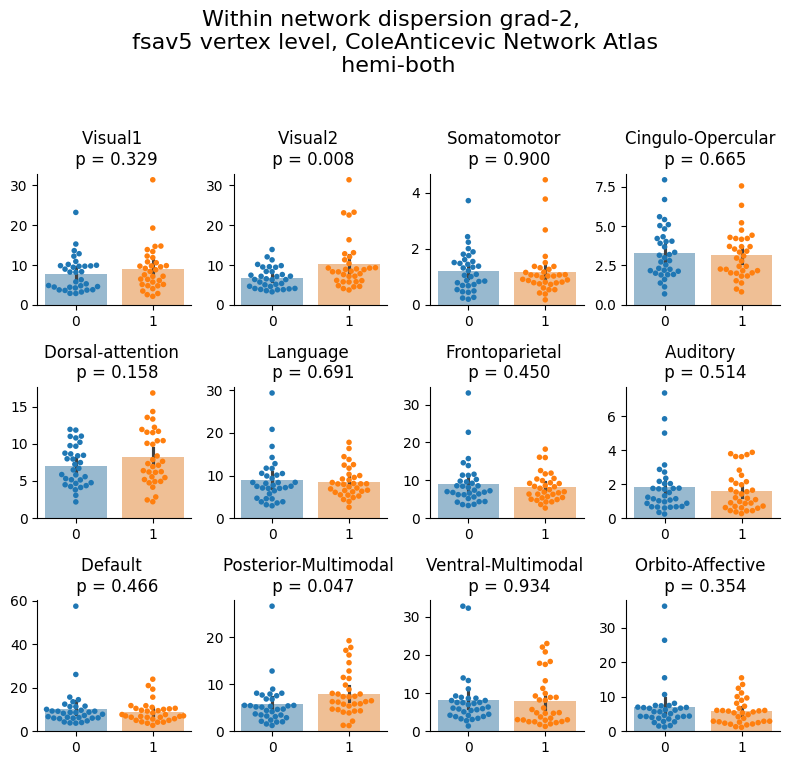

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

network_atlas = 'ColeAnticevic'
network_names = CAatlas_names
hemi = 'both'
#tmp = df.loc[df.abs().mean(axis=1) < 100].reset_index() # remove outlier subjects (weird gradient loading scale due to >1 connected components)
tmp = df.reset_index()

n_cols = 4  # Number of columns in the subplot grid
n_rows = int((N_nets) / n_cols)  # Calculate rows needed for N_nets subplots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8)) # , sharex=True, sharey=True
fig.suptitle(f'{measure_of_interest} grad-{n_grad}, \n fsav5 vertex level, {network_atlas} Network Atlas \n hemi-{hemi}', fontsize=16)

pvals = []
for i in range(N_nets):
    ax = axes[i // n_cols, i % n_cols]  # Calculate position in grid
    net_label_number = (i+1)
    net_name= network_names.loc[net_label_number].item()

    data_net = tmp[f'net_{i + 1}']
    _, p_value = ttest_ind(data_net[tmp['group'] == 0], data_net[tmp['group'] == 1], equal_var=False)  # Welch's t-test
    
    #sns.kdeplot(data=tmp, x=f'net_{net_label_number}', hue='group', ax=ax, fill=True,legend=False)
    #sns.violinplot(data=tmp, y=f'net_{net_label_number}', hue='group', ax=ax, fill=True,legend=False,split=True, gap=.1, alpha= 0.7)
    sns.barplot(data=tmp.reset_index(), x ='group', hue='group',y=f'net_{net_label_number}', alpha=0.5,legend=False, ax=ax)
    sns.swarmplot(data=tmp.reset_index(),  x ='group', hue='group',y=f'net_{net_label_number}', size=4,legend=False, ax=ax)
    ax.set_title(f'{net_name} \n p = {p_value:.3f}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    pvals.append(p_value)

sns.despine()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the suptitle
plt.show()

pvals = np.array(pvals)

In [26]:
# Multiple comparison correction! 

# Apply Bonferroni correction
bonferroni_corrected_pvals = pvals * len(pvals) # np.minimum(
print(bonferroni_corrected_pvals)

# Apply Benjamini-Hochberg FDR correction
from statsmodels.stats.multitest import multipletests
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
pvals_corrected

[ 3.94208545  0.09343398 10.79498242  7.97905061  1.90174143  8.29785465
  5.40178719  6.16328867  5.59720519  0.5635477  11.20888362  4.25181868]


array([0.77041108, 0.09343398, 0.93407364, 0.82978547, 0.63391381,
       0.82978547, 0.77041108, 0.77041108, 0.77041108, 0.28177385,
       0.93407364, 0.77041108])

# Between network


In [27]:
from scipy.stats import ttest_ind

test_name = '2sample_TTest'

N_nets = 12
mat_pvals = np.ones([N_nets, N_nets])
mat_rs = np.zeros([N_nets, N_nets]) # = Tvals !
mat_outliers = np.zeros([N_nets, N_nets])

distances = []
net_name_comps = []
for n1 in range(N_nets):
    for n2 in range(n1, N_nets):
        #print(n1, n2)
        distance = np.abs(centroids_net[n1] - centroids_net[n2]) # (12, 66)
        distances.append(distance)

        df = pd.DataFrame(np.array(distance.T), index=sub_array,columns=['net_distance'])
        df.index.name = 'subject'
        df = df.join(group_list['group']).set_index('group',append=True)
        t_stat, p_val = ttest_ind(df.xs(0,0,'group'), df.xs(1,0,'group'), equal_var=False)  # Welch's t-test

        mat_rs[n1,n2] = np.round(t_stat, 3)
        mat_pvals[n1,n2] =  np.round(p_val, 4)

        net_name_comps.append(str(CAatlas_names.loc[n1+1]['Network Name']) +  ' - ' + str(CAatlas_names.loc[n2+1]['Network Name']))


/tmp/ipykernel_3461916/3557979370.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_rs[n1,n2] = np.round(t_stat, 3)
/tmp/ipykernel_3461916/3557979370.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_pvals[n1,n2] =  np.round(p_val, 4)
/tmp/ipykernel_3461916/3557979370.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_rs[n1,n2] = np.round(t_stat, 3)
/tmp/ipykernel_3461916/3557979370.py:24: DeprecationWarning: Conversion of an array with ndim > 0

Text(0.5, 1.1, '2sample_TTest Between network distance group difference (T-stat) \n Grad 2')

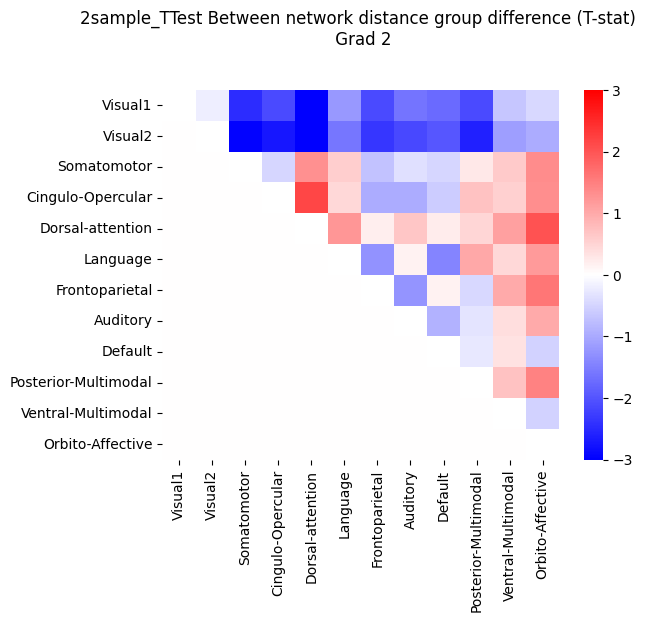

In [31]:
sns.heatmap(mat_rs, cmap='bwr',vmin=-3,vmax=3,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'{test_name} Between network distance group difference (T-stat) \n Grad {n_grad}', y=1.1)

Text(0.5, 1.02, 'P-vals of between group TTEst on between network distances \n Grad 2')

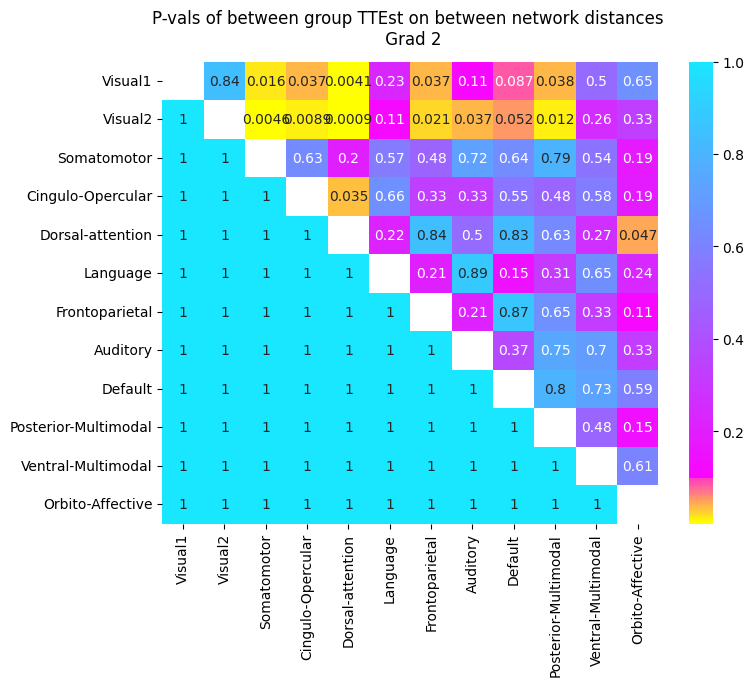

In [29]:
from utils_02 import get_pval_colormap
pval_cmap = get_pval_colormap()

fig, axes = plt.subplots(1,1, figsize=(8,6)) # , sharex=True, sharey=True

sns.heatmap(mat_pvals, cmap=pval_cmap,annot=True,ax=axes, #vmin=-0.4,vmax=0.4,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'P-vals of between group TTEst on between network distances \n Grad {n_grad}', y=1.02)

Text(0.5, 1.01, 'Corrected  P-vals \n 2sample_TTest - between network distance \n 2D gradient space')

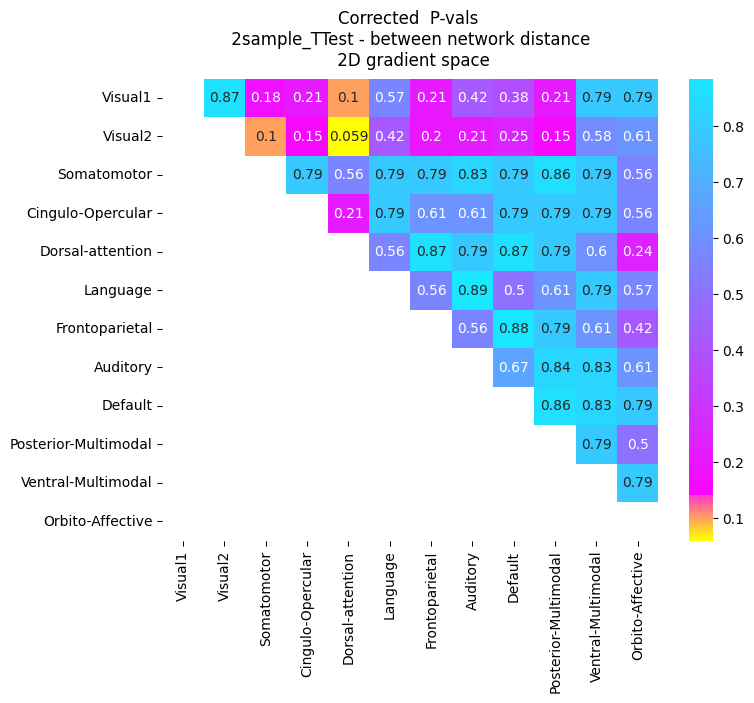

In [30]:
pvals = mat_pvals.flatten()
pvals = pvals[pvals != 1]
pvals = [x for x in pvals if not np.isnan(x)]
pvals

# Apply Benjamini-Hochberg FDR correction
from statsmodels.stats.multitest import multipletests
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
#print(pvals_corrected)

mask = (mat_pvals != 1) & ~np.isnan(mat_pvals)
corrected_mat_pvals = np.full(mat_pvals.shape, np.nan)
corrected_mat_pvals[mask] = pvals_corrected


fig, axes = plt.subplots(1,1, figsize=(8,6)) # , sharex=True, sharey=True
sns.heatmap(corrected_mat_pvals, cmap=pval_cmap,annot=True,ax=axes, #vmin=0.05,vmax=0.4,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'Corrected  P-vals \n {test_name} - between network distance \n 2D gradient space', y=1.01)

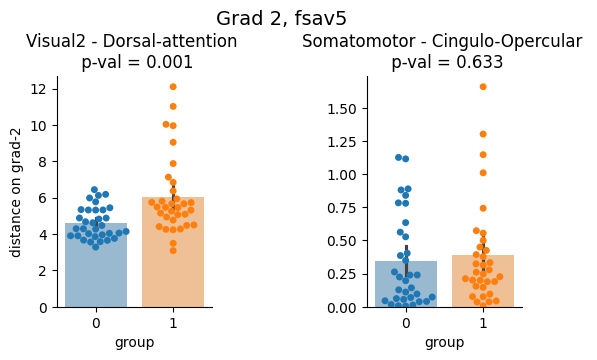

In [40]:

df_dist = pd.DataFrame(np.array(distances).T, index=sub_array, columns=net_name_comps)
df_dist.index.name = 'subject'
df_dist = df_dist.join(group_list).set_index('group',append=True)

network_combinations = ['Visual2 - Dorsal-attention','Somatomotor - Cingulo-Opercular' ] #  Dorsal-attention
fig, axes = plt.subplots(1,len(network_combinations), figsize=(len(network_combinations) * 3,3)) # , sharex=True, sharey=True

for i, net_comb in enumerate(network_combinations):
    sns.barplot(data=df_dist.reset_index(), x ='group', hue='group',y=net_comb, alpha=0.5,legend=False, ax=axes[i])
    sns.swarmplot(data=df_dist.reset_index(),  x ='group', hue='group',y=net_comb, size=5,legend=False, ax=axes[i])

    t_stat, p_val = ttest_ind(df_dist.xs(0,0,'group')[net_comb], df_dist.xs(1,0,'group')[net_comb], equal_var=False)  # Welch's t-test
    p_val = np.round(p_val,3)
    axes[i].set(title=f'{net_comb} \n p-val = {p_val}', ylabel='')
sns.despine()
axes[0].set(ylabel=f'distance on grad-{n_grad}')
fig.suptitle(f'Grad {n_grad}, fsav5', fontsize=14,y=1.1)
fig.subplots_adjust(wspace=1)


In [41]:
# save phenotypes
df_dist.to_csv(op.join(phenotype_folder,f'betweenNdispersion_grad-{n_grad}.csv'))

df_within = pd.DataFrame(np.array(WN_dispersion.T), index=sub_array, columns = CAatlas_names['Network Name'])
df_within.index.name = 'subject'
df_within.to_csv(op.join(phenotype_folder,f'withinNdispersion_grad-{n_grad}.csv'))

In [40]:
df_within

Network Name,Visual1,Visual2,Somatomotor,Cingulo-Opercular,Dorsal-attention,Language,Frontoparietal,Auditory,Default,Posterior-Multimodal,Ventral-Multimodal,Orbito-Affective
subject,,,,,,,,,,,,
21,10.153303,7.447543,0.447357,2.318246,10.196372,3.833786,4.340712,0.334249,6.186380,6.862615,3.266913,1.647554
59,4.858531,9.504181,1.615940,6.681286,11.832134,29.381217,33.073216,7.357532,57.559211,2.382463,32.233785,36.240248
54,9.705321,11.298490,1.447574,3.905404,7.972687,12.785947,14.621594,2.159586,14.537462,3.476138,13.964811,15.498421
15,15.263112,7.208842,0.498589,5.591301,9.741935,9.886217,6.609338,0.594399,8.797887,8.087584,8.053012,6.898699
52,5.280768,4.619278,0.201913,0.696613,2.176468,2.892484,3.318138,0.237398,4.791546,1.961261,4.157670,2.737301
...,...,...,...,...,...,...,...,...,...,...,...,...
28,4.481891,5.157240,0.469556,1.930742,4.662209,8.371114,6.191998,1.743734,9.322392,1.555211,3.385049,4.310111
42,13.869658,7.608506,1.051228,7.543673,10.412096,16.345878,11.688378,0.971728,10.096588,11.442269,9.912313,9.655358
25,3.471827,7.163409,1.173535,2.966603,6.926468,8.043301,6.347345,3.787230,6.896070,9.825989,2.892357,5.321791


## Between network Correlations with behavioral scores

needs `centroids_net` from above

In [86]:
# get gradient values, vertex x subject

n_grad =2
group = 'All' # 0 #

if group == 'All':
    subList_group = subList
else:
    subList_group = group_list[group_list['group']== group].reset_index()['subject'].values

gms_aligned = [None] * len(subList_group)
for i, sub in enumerate(subList_group):
    sub = '%02d' % int(sub)
    source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
    gm_aligned = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_space-fsaverag5_n10.npy')) # sub-01_g-aligned_space-fsaverag5_n10.npy
    gms_aligned[i] = gm_aligned[n_grad-1,:] # only one grad to start with

# to create multidimensional array with all subs, grads & parcels, look at asym_grad....
sub_array= np.array([int(i) for i in subList_group]) 
n_vertices = np.shape(gms_aligned)[1] # 180

gradients = np.array(gms_aligned).T # n_vertices x n_subjects
N_nets = len(np.unique(caNets_fsav5_mapping)[1:]) # remove network-label=0

centroids_net = []  # center of gravity (median) for given network (i.e., network centroid position) (7 x 1000)

for n_network in np.unique(caNets_fsav5_mapping)[1:]:
    # identify the nodes of given network
    netNodes = np.where(caNets_fsav5_mapping == (n_network))[0] # get (glasser space) indices
    netNodes = np.squeeze(netNodes)
    
    # get the gradient loadings of the nodes of the given  network, for each subject (shape: number of nodes in network x N)
    G1_net = gradients[netNodes]
    centroid_cog_net = np.nanmedian(G1_net, axis=0)  #np.median(G1_net, axis=0)  
    centroids_net.append(centroid_cog_net)
    
centroids_net = np.array(centroids_net)


In [87]:
# correlation with behavior?!
y_var = 'skill_score' #'perceptual_noise_sd_unbiased'
x_var = 'net_distance'

N_nets = 12
mat_pvals = np.ones([N_nets, N_nets])
mat_rs = np.zeros([N_nets, N_nets])
mat_outliers = np.zeros([N_nets, N_nets])

distances = []
net_name_comps = []
for n1 in range(N_nets):
    for n2 in range(n1, N_nets):
        #print(n1, n2)
        distance = np.abs(centroids_net[n1] - centroids_net[n2]) # (12, 66)
        distances.append(distance)

        df = pd.DataFrame(np.array(distance.T), index=sub_array,columns=['net_distance'])
        df.index.name = 'subject'
        df_comb = df.join(df_behav).join(group_list).set_index('group',append=True)
        cor = pingouin.corr(df_comb[y_var], df_comb[x_var], method = 'spearman') #defautl: two -sided & pearson 

        mat_rs[n1,n2] = np.round(cor['r'].iloc[0], 2)
        mat_pvals[n1,n2] = np.round(cor['p-val'].iloc[0], 5)

        net_name_comps.append(str(CAatlas_names.loc[n1+1]['Network Name']) +  ' - ' + str(CAatlas_names.loc[n2+1]['Network Name']))


/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/hom

Text(0.5, 1.1, 'Correlation Coefficients of skill_score with between network distance \n Grad 2, group-All')

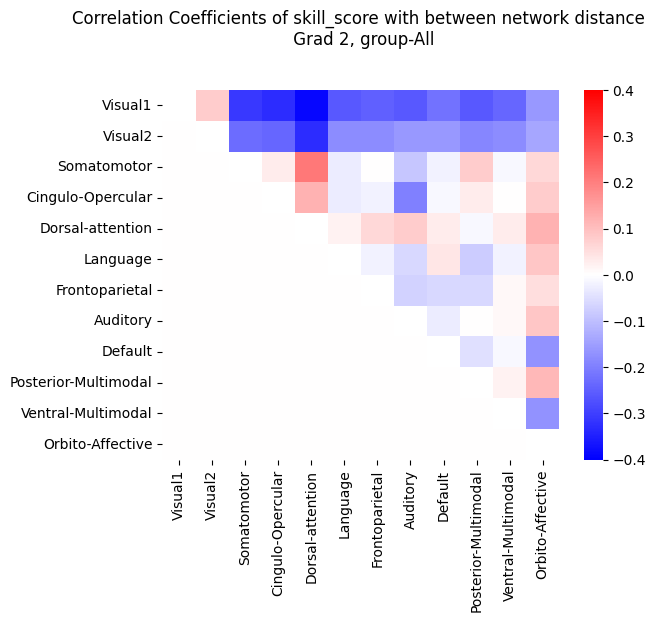

In [88]:
sns.heatmap(mat_rs, cmap='bwr',vmin=-0.4,vmax=0.4,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'Correlation Coefficients of {y_var} with between network distance \n Grad {n_grad}, group-{group}', y=1.1)

Text(0.5, 1.01, 'Correlation P-vals of skill_score with between network distance \n Grad 2, group-All')

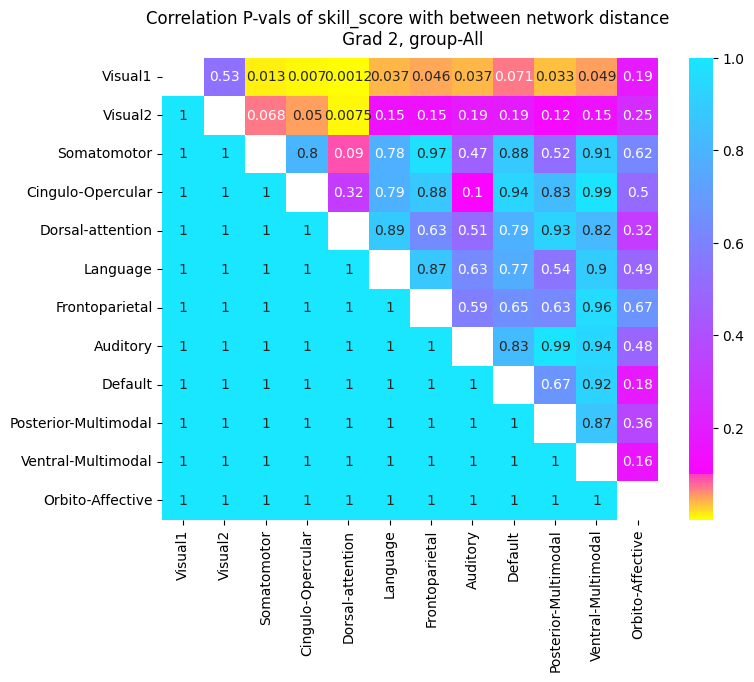

In [89]:
from utils_02 import get_pval_colormap
pval_cmap = get_pval_colormap()

fig, axes = plt.subplots(1,1, figsize=(8,6)) # , sharex=True, sharey=True

sns.heatmap(mat_pvals, cmap=pval_cmap,annot=True,ax=axes, #vmin=-0.4,vmax=0.4,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'Correlation P-vals of {y_var} with between network distance \n Grad {n_grad}, group-{group}', y=1.01)

In [93]:
pvals = mat_pvals.flatten()
pvals = pvals[pvals != 1]
pvals = [x for x in pvals if not np.isnan(x)]
pvals

# Apply Benjamini-Hochberg FDR correction
from statsmodels.stats.multitest import multipletests
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
#print(pvals_corrected)

mask = (mat_pvals != 1) & ~np.isnan(mat_pvals)
corrected_mat_pvals = np.full(mat_pvals.shape, np.nan)
corrected_mat_pvals[mask] = pvals_corrected

Text(0.5, 1.01, 'Corrected Correlation P-vals of skill_score with between network distance \n Grad 2, group-All')

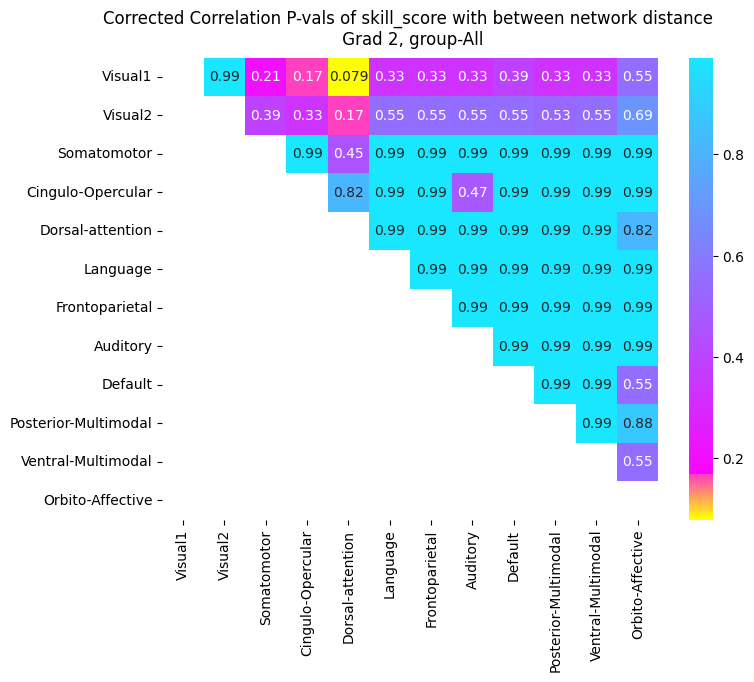

In [92]:
from utils_02 import get_pval_colormap
pval_cmap = get_pval_colormap()

fig, axes = plt.subplots(1,1, figsize=(8,6)) # , sharex=True, sharey=True

sns.heatmap(corrected_mat_pvals, cmap=pval_cmap,annot=True,ax=axes, #vmin=-0.4,vmax=0.4,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'Corrected Correlation P-vals of {y_var} with between network distance \n Grad {n_grad}, group-{group}', y=1.01)

### test formaly!

In [58]:
df_dist = pd.DataFrame(np.array(distances).T, index=sub_array, columns=net_name_comps)
df_dist.index.name = 'subject'

df_comb = df_dist.join(df_behav).join(group_list['age'])
df_comb.head()

,,Visual1 - Visual1,Visual1 - Visual2,Visual1 - Somatomotor,Visual1 - Cingulo-Opercular,Visual1 - Dorsal-attention,Visual1 - Language,Visual1 - Frontoparietal,Visual1 - Auditory,Visual1 - Default,Visual1 - Posterior-Multimodal,...,basisscore,overall_score,erfassungsspanne,memory_noise_sd_unbiased,perceptual_noise_sd_unbiased,skill_score,visio-spatial IQ,verbal IQ,mean_iq,age
subject,group,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,1.402905,4.190394,4.230300,2.178592,5.555095,7.531992,4.166415,10.345711,2.323222,...,5,13.0,8,0.115213,0.102558,36.0,120.0,105.0,112.5,19.0
2,1,0.0,1.099509,7.686998,7.947067,7.467926,8.282643,8.851833,6.505791,10.442199,4.798521,...,5,10.0,6,0.196658,0.122329,6.0,100.0,95.0,97.5,17.0
3,0,0.0,0.591968,5.474046,5.436193,4.644978,6.053466,7.113284,3.894287,8.621674,3.709063,...,4,7.0,5,0.213540,0.150741,29.0,115.0,95.0,105.0,15.0
4,1,0.0,1.084777,5.950618,4.648078,4.576615,5.753830,9.287642,4.442315,10.789755,4.657397,...,4,7.0,6,0.105920,0.091129,34.0,110.0,105.0,107.5,17.0
5,0,0.0,0.246506,4.964455,4.184060,4.044178,4.257200,5.161986,3.556554,6.423705,2.677200,...,4,10.0,7,0.127888,0.153583,30.0,90.0,115.0,102.5,20.0


In [59]:
x_var = 'skill_score'#'memory_noise_sd' #'perceptual_noise_sd' # 'Percent Correct'# _unbiased 'memory_noise_sd_unbiased ''skill_score'#'
y_var =    'Visual1 - Cingulo-Opercular'# 'Visual2 - Dorsal-attention'# 

#formula1 = 'neuralVar ~ behaveVar + group + age'
formula2 = 'behaveVar ~ neuralVar + group + age'

import statsmodels.api as sm

df_comb['neuralVar'] = np.log(df_comb[y_var])
df_comb['behaveVar'] = np.log(df_comb[x_var])

result = sm.formula.ols(formula=formula2, data=df_comb.reset_index()).fit()
print()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              behaveVar   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     12.09
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           2.51e-06
Time:                        16:15:46   Log-Likelihood:                -47.367
No. Observations:                  66   AIC:                             102.7
Df Residuals:                      62   BIC:                             111.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4957      0.590      5.926      0.000       2.316       4.675
neuralVar     -0.2723      0.247     -1.103      0.274      -0.766       0.221
group         -0.6709      0.139     -4.824      0.000      -0.949      -0.393
age            0.0195      0.023      0.846      0.401      -0.026       0.065
==============================================================================
Omnibus:                       13.672   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.382
Skew:                          -0.955   Prob(JB):                     0.000457
Kurtosis:                       4.394   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
n1 = 1 -1#(visual1)
n2 = 4  -1#
net_name_comp =(CAatlas_names.loc[n1+1]['Network Name']) + ' -to- ' + (CAatlas_names.loc[n2+1]['Network Name'])

distance = centroids_net[n1] - centroids_net[n2] # (12, 66)
df = pd.DataFrame(np.array(distance.T), index=sub_array,columns=['net_distance'])
df.index.name = 'subject'
df_comb = df.join(df_behave).join(group_list).set_index('group',append=True)

/tmp/ipykernel_1459711/619427700.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_ = np.round(cor['r'][0], 2)
/tmp/ipykernel_1459711/619427700.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = np.round(cor['p-val'][0], 5)


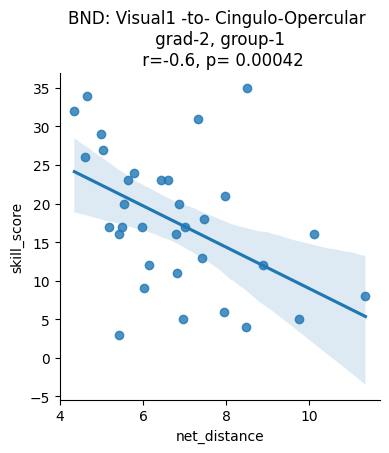

In [77]:
import pingouin

y_var = 'skill_score' #'perceptual_noise_sd' # 'Percent Correct'#
x_var = 'net_distance'
cor = pingouin.corr(df_comb[y_var], df_comb[x_var], method = 'shepherd') #defautl: two -sided & pearson 
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

fig = sns.lmplot(x=x_var, y=y_var, data=df_comb,height=4, robust=True) #  hue='group',
fig.set(title=f'BND: {net_name_comp} \n grad-{n_grad}, group-{group} \n r={r_}, p= {p}' ) 

Text(0.5, 1.0, 'group-1 \n mean=6.76')

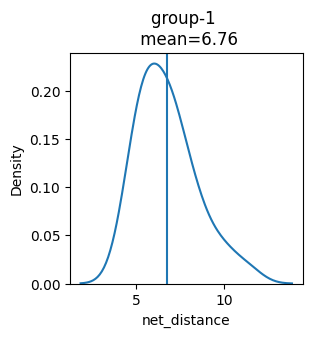

In [78]:
plt.figure(figsize=(3,3))
mean_ = np.round(df['net_distance'].mean(),2)
sns.kdeplot(df,x='net_distance')
plt.axvline(mean_)
plt.title(f'group-{group} \n mean={mean_}')

## Look at network dispersion 

In [125]:
n_grad = 1
gms = gms_aligned_g2 if n_grad == 2 else gms_aligned_g1
df = pd.DataFrame(gms, index=sub_array, columns = [f"vertex_{i+1}" for i in range(np.shape(gms_aligned_g1)[1])])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)

df = pd.DataFrame(np.array([df.xs(0,0,'group').mean().values, df.xs(1,0,'group').mean().values, caNets_fsav5_mapping]).T,
                         columns =['control','dyscalc','ca_network' ]) 


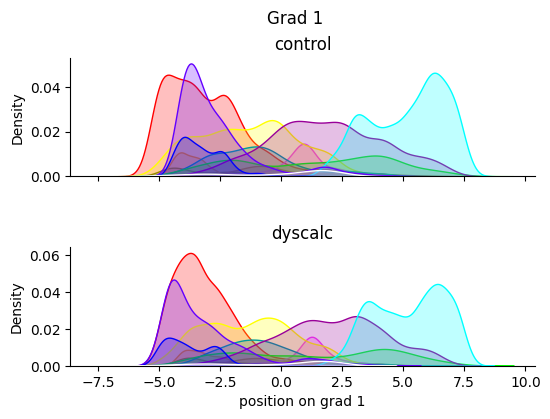

In [126]:
import hcp_utils as hcp
from matplotlib.colors import ListedColormap
import seaborn as sns
rgb = np.array(list(hcp.ca_network['rgba'].values())[1:])
ca_cmap = ListedColormap(np.vstack(([1, 1, 1, 1], rgb)), 'custom_colormap') # add white infront, 0=unknown, 1-12 actual labels

fig, axs = plt.subplots(2,1,figsize=(6,4), sharex=True)
sns.kdeplot(df,hue='ca_network',x='control',fill=True,palette=ca_cmap, ax=axs[0],legend=False )
sns.kdeplot(df,hue='ca_network',x='dyscalc',fill=True,palette=ca_cmap, ax=axs[1],legend=False )
fig.subplots_adjust(hspace=0.6)
axs[0].set(title='control')#, xlim=(-6.5,9))
axs[1].set(title='dyscalc', xlabel=f'position on grad {n_grad}')#, xlim=(-6.5,9))
fig.suptitle(f'Grad {n_grad}',y=1)

sns.despine()


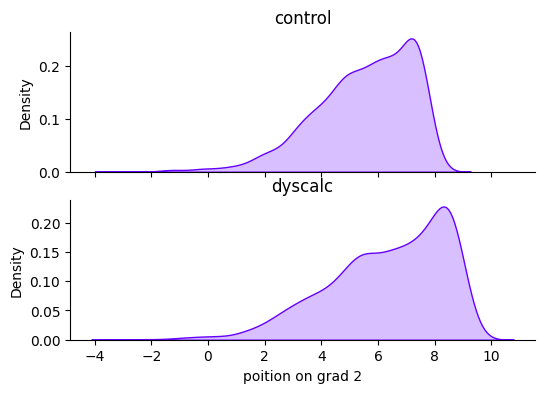

In [ ]:
network_label = 2
temp = df[df['ca_network'] == network_label]
fig, axs = plt.subplots(2,1,figsize=(6,4), sharex=True)
sns.kdeplot(temp,x='control',fill=True,color=rgb[int(network_label-1)], ax=axs[0],legend=False )
sns.kdeplot(temp,x='dyscalc',fill=True,color=rgb[int(network_label-1)], ax=axs[1],legend=False )
axs[0].set(title='control')#, xlim=(-6.5,9))
axs[1].set(title='dyscalc', xlabel=f'position on grad {n_grad}')#, xlim=(-6.5,9))
sns.despine()


In [ ]:
gms_g1 =  pd.DataFrame(gms_aligned_g1, index=sub_array).join(group_list).set_index('group',append=True)
gms_g2 =  pd.DataFrame(gms_aligned_g2, index=sub_array).join(group_list).set_index('group',append=True)

# dropping "outlier" 43 does not change the pattern
#gms_g1 =  pd.DataFrame(gms_aligned_g1, index=sub_array).drop(43).join(group_list).set_index('group',append=True)
#gms_g2 =  pd.DataFrame(gms_aligned_g2, index=sub_array).drop(43).join(group_list).set_index('group',append=True)

grads = np.array([gms_g1.groupby('group').mean().loc[0], gms_g1.groupby('group').mean().loc[1],
                  gms_g2.groupby('group').mean().loc[0], gms_g2.groupby('group').mean().loc[1], 
                  caNets_fsav5_mapping])
df = pd.DataFrame(grads.T, columns =['g1_control','g1_dyscalc','g2_control','g2_dyscalc','ca_network']) 

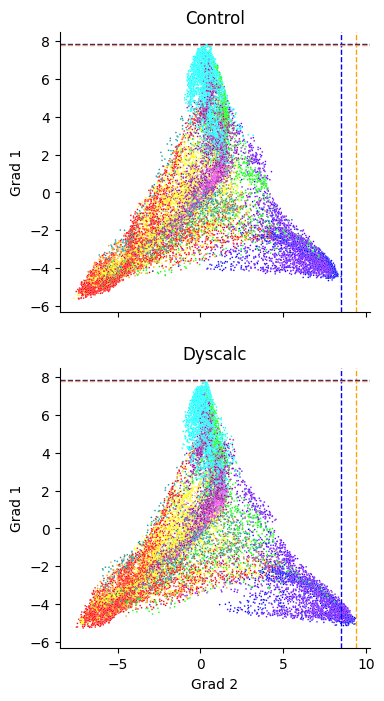

In [140]:
fig, axs = plt.subplots(2,1,figsize=(4,8), sharex=True, sharey=True)

sns.scatterplot(df, x='g2_control', y='g1_control', hue='ca_network',palette=ca_cmap,s=1.4, legend=False,ax=axs[0] )
sns.scatterplot(df, x='g2_dyscalc', y='g1_dyscalc', hue='ca_network',palette=ca_cmap,s=1.4, legend=False,ax=axs[1] )
axs[1].set(title='Dyscalc',xlabel='Grad 2',ylabel='Grad 1')
axs[0].set(title='Control',ylabel='Grad 1')

# Add guiding line
for ax in axs:
    ax.axvline(x=df['g2_control'].max(), color='blue', linestyle='--', linewidth=1)
    ax.axvline(x=df['g2_dyscalc'].max(), color='orange', linestyle='--', linewidth=1)
    ax.axhline(y=df['g1_control'].max(), color='blue', linestyle='--', linewidth=1)
    ax.axhline(y=df['g1_dyscalc'].max(), color='orange', linestyle='--', linewidth=1)

sns.despine()

### Within Network Correlation with behavioral scores

needs `within network dispersion dataFrame` from all the way above! 

In [ ]:
# within network dispersion dataFrame from all the way above! 
df.head()

,,net_1,net_2,net_3,net_4,net_5,net_6,net_7,net_8,net_9,net_10,net_11,net_12
subject,group,,,,,,,,,,,,
21,0,10.153303,7.447543,0.447357,2.318246,10.196372,3.833786,4.340712,0.334249,6.186380,6.862615,3.266913,1.647554
59,0,4.858531,9.504181,1.615940,6.681286,11.832134,29.381217,33.073216,7.357532,57.559211,2.382463,32.233785,36.240248
54,0,9.705321,11.298490,1.447574,3.905404,7.972687,12.785947,14.621594,2.159586,14.537462,3.476138,13.964811,15.498421
15,0,15.263112,7.208842,0.498589,5.591301,9.741935,9.886217,6.609338,0.594399,8.797887,8.087584,8.053012,6.898699
52,0,5.280768,4.619278,0.201913,0.696613,2.176468,2.892484,3.318138,0.237398,4.791546,1.961261,4.157670,2.737301


In [28]:
source_folder = op.join(bids_folder, 'derivatives/phenotype')
magjudge_bauer_params = pd.read_csv(op.join(source_folder,f'magjudge_bauer-3_sds.csv')).set_index('subject')
vs_wm = pd.read_csv(op.join(source_folder, 'visio-spatial-WM_CBTtask-params.csv')).set_index('subject')
pana = pd.read_csv(op.join(source_folder, 'ANSacuity_panamath.csv')).set_index('subject')

df_behave = pana.join(magjudge_bauer_params).join(vs_wm).set_index('group', append=True)
df_behave['weber_frac_log'] = np.log(df_behave['weber_frac'])
df_behave.columns

Index(['weber_frac', 'Percent Correct', 'memory_noise_sd',
       'perceptual_noise_sd', 'basisscore', 'overall_score',
       'erfassungsspanne', 'weber_frac_log'],
      dtype='object')

In [40]:
df_comb = df.join(df_behave).reset_index() # #drop(43).

/tmp/ipykernel_293423/18954179.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_ = np.round(cor['r'][0], 2)
/tmp/ipykernel_293423/18954179.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = np.round(cor['p-val'][0], 3)


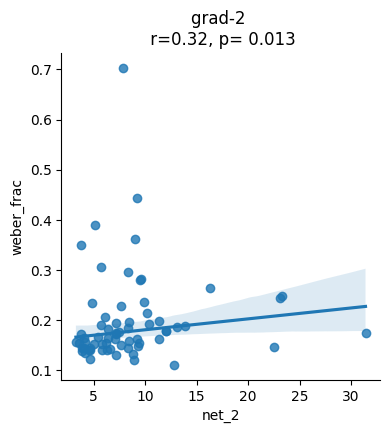

In [51]:
import pingouin

y_var = 'weber_frac' #'perceptual_noise_sd' # 'Percent Correct'#
x_var = 'net_2'
cor = pingouin.corr(df_comb[y_var], df_comb[x_var], method = 'shepherd') #defautl: two -sided & pearson 
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 3)

fig = sns.lmplot(x=x_var, y=y_var, data=df_comb,height=4, robust=True) #  hue='group',
fig.set(title=f'grad-{n_grad} \n r={r_}, p= {p}' ) 

In [47]:
cor

,n,outliers,r,CI95%,p-val,power
shepherd,66,5,-0.248599,"[-0.47, 0.0]",0.053372,0.495011


In [ ]:
# correlation with behavior?!
y_var = 'skill_score' #'perceptual_noise_sd_unbiased'
x_var = 'net_distance'

mat_pvals = np.ones([N_nets, N_nets])
mat_rs = np.zeros([N_nets, N_nets])
mat_outliers = np.zeros([N_nets, N_nets])

BN_dispersions = {'pairwise_comparison' : []}
distances = []
net_name_comps = []
for n1 in range(N_nets):
    for n2 in range(N_nets):
        current_pairwise_comparison = [n1+1, n2+1]
        if n1!=n2 and [n1+1, n2+1] not in BN_dispersions['pairwise_comparison'] and list(reversed([n1+1, n2+1])) not in BN_dispersions['pairwise_comparison']:
            BN_dispersions['pairwise_comparison'].append(current_pairwise_comparison)

            distance = np.abs(centroids_net[n1] - centroids_net[n2]) # (12, 66)
            df = pd.DataFrame(np.array(distance.T), index=sub_array,columns=['net_distance'])
            df.index.name = 'subject'
            df_comb = df.join(df_behav).join(group_list).set_index('group',append=True)
            cor = pingouin.corr(df_comb[y_var], df_comb[x_var], method = 'spearman') #defautl: two -sided & pearson 

            mat_rs[n1,n2] = np.round(cor['r'].iloc[0], 2)
            mat_pvals[n1,n2] = np.round(cor['p-val'].iloc[0], 3)
            #mat_outliers[n1,n2] = cor['outliers'].iloc[0]
            net_name_comps.append(str(CAatlas_names.loc[n1+1]['Network Name']) +  ' - ' + str(CAatlas_names.loc[n2+1]['Network Name']))
            distances.append(distance)


